#Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is levaraging a working odel's existing architecture and learned patterns for our own problems.
There are two main benefits:
1. Can levarage an existing neural network architecture proven to work on problems similar to our own.
2. Can levarage a working neural network architecture which has already learned patterns on similar data to our own then we can adapt those patterms to our own data

In [ ]:
#Are we using a GPU
!nvidia-smi

Tue Mar 14 13:49:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Downloading the data (10% of the food data )!!
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-03-15 16:20:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.251.31.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  37.3MB/s    in 5.0s    

2023-03-15 16:20:05 (32.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#How many images in each folder
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 10 directori

In [ ]:
#Create some data loaders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size = IMAGE_SHAPE,
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = "categorical")


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Setting up callbacks while our model trains
Callbacks are extra functionality you can add to your model to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the Tensorboard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training with the EarlyStopping callback

In [ ]:
#Creating a tensorboard callback (functionized because we need to create a new one for every model)
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving tensorboard log files to {log_dir}")
  return tensorboard_callback


In [ ]:
#Creating models using TensorFlow hub
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

mobilenetv2_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"


In [ ]:
#Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
#Lets make a create model function to create a model from a URL
def create_model (model_url,num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name="feature_extraction",
                                           input_shape = IMAGE_SHAPE+(3,))

  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation="softmax",name="output_layer")


  return model


In [ ]:
import pathlib
import numpy as np
data_dir = pathlib.Path("10_food_classes_10_percent/train/")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names = class_names[:]
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [ ]:
#Create Resnet tensorflowhub feature extraction model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [ ]:
#Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction (KerasLa  (None, 2048)             23564800  
 yer)                                                            
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data_10_percent,
                                  validation_steps = len(test_data_10_percent),
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                           experiment_name = "resnet50v2")])

Saving tensorboard log files to tensorflow_hub/resnet50v2/20230314-144414
Epoch 1/5
24/24 [==============================] - 23s 848ms/step - loss: 1.8842 - accuracy: 0.3920 - val_loss: 1.1894 - val_accuracy: 0.6220
Epoch 2/5
24/24 [==============================] - 17s 716ms/step - loss: 0.8900 - accuracy: 0.7320 - val_loss: 0.8471 - val_accuracy: 0.7316
Epoch 3/5
24/24 [==============================] - 17s 738ms/step - loss: 0.6275 - accuracy: 0.8280 - val_loss: 0.7551 - val_accuracy: 0.7600
Epoch 4/5
24/24 [==============================] - 17s 712ms/step - loss: 0.4742 - accuracy: 0.8853 - val_loss: 0.7012 - val_accuracy: 0.7692
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.3801 - accuracy: 0.9173 - val_loss: 0.6852 - val_accuracy: 0.7720


In [ ]:
resnet_model.evaluate(test_data_10_percent)

79/79 [==============================] - 14s 171ms/step - loss: 0.7040 - accuracy: 0.7656


[0.7039613723754883, 0.7656000256538391]

In [ ]:
def load_and_prep_image(filename,img_shape = 224):
  img= tf.io.read_file(filename)
  img = tf.image.decode_image(img)
  img = tf.image.resize(img,size = [img_shape,img_shape])
  img = img/255.
  return img

In [ ]:
def show_predictions(model,filename,class_names):
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img,axis=0))
  if (len(pred[0])>1):
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred))]
  return pred_class

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

--2023-03-14 14:07:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1725178 (1.6M) [image/jpeg]
Saving to: ‘03-sushi.jpeg’

03-sushi.jpeg       100%[===================>]   1.64M  --.-KB/s    in 0.06s   

2023-03-14 14:07:19 (28.1 MB/s) - ‘03-sushi.jpeg’ saved [1725178/1725178]



In [ ]:
show_predictions(model = resnet_model,filename = "03-sushi.jpeg",class_names = class_names)

1/1 [==============================] - 0s 33ms/step


'sushi'

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg


--2023-03-14 14:12:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3564285 (3.4M) [image/jpeg]
Saving to: ‘03-hamburger.jpeg’

03-hamburger.jpeg   100%[===================>]   3.40M  --.-KB/s    in 0.07s   

2023-03-14 14:12:15 (50.4 MB/s) - ‘03-hamburger.jpeg’ saved [3564285/3564285]



In [ ]:
show_predictions(model = resnet_model, filename = "03-hamburger.jpeg", class_names = class_names)

1/1 [==============================] - 0s 27ms/step


'hamburger'

In [ ]:
import matplotlib.pyplot as plt

#Plot the validation and training curves

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label= "Training loss")
  plt.plot(epochs, val_loss, label = "Validatoin Loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="Training accuracy")
  plt.plot(epochs, val_accuracy, label = "Validation accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

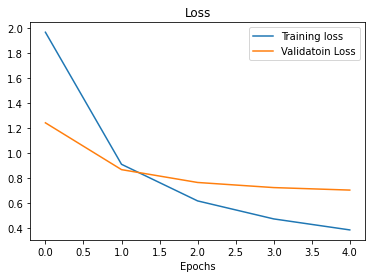

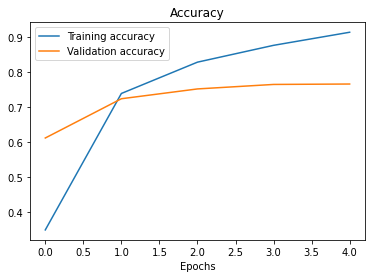

In [ ]:
plot_loss_curves(resnet_history)

Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
efficientnet_model = create_model(model_url = efficientnet_url,
                               num_classes = train_data_10_percent.num_classes)

In [ ]:
efficientnet_model.compile(loss="categorical_crossentropy",
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs = 5,
                                              validation_data = test_data_10_percent,
                                              steps_per_epoch = len(train_data_10_percent),
                                              validation_steps = len(test_data_10_percent),
                                              callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                                       experiment_name = "efficientnetb0")])

Saving tensorboard log files to tensorflow_hub/efficientnetb0/20230314-144051
Epoch 1/5
24/24 [==============================] - 36s 1s/step - loss: 1.8410 - accuracy: 0.4400 - val_loss: 1.2745 - val_accuracy: 0.7244
Epoch 2/5
24/24 [==============================] - 16s 697ms/step - loss: 1.0527 - accuracy: 0.7627 - val_loss: 0.8568 - val_accuracy: 0.8180
Epoch 3/5
24/24 [==============================] - 16s 692ms/step - loss: 0.7524 - accuracy: 0.8360 - val_loss: 0.6870 - val_accuracy: 0.8452
Epoch 4/5
24/24 [==============================] - 17s 721ms/step - loss: 0.6056 - accuracy: 0.8640 - val_loss: 0.6057 - val_accuracy: 0.8604
Epoch 5/5
24/24 [==============================] - 16s 679ms/step - loss: 0.5146 - accuracy: 0.8907 - val_loss: 0.5505 - val_accuracy: 0.8636


In [ ]:
mobilenetv2_model = create_model(mobilenetv2_url,
                                 num_classes=train_data_10_percent.num_classes)

In [ ]:
mobilenetv2_model.compile(loss = "categorical_crossentropy",
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics = "accuracy")

mobilenetv2_history = mobilenetv2_model.fit(train_data_10_percent,
                      epochs = 5,
                      steps_per_epoch = len(train_data_10_percent),
                      validation_data = test_data_10_percent,
                      validation_steps = len(test_data_10_percent),
                      callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                           experiment_name = "mobilenetv2")])

Saving tensorboard log files to tensorflow_hub/mobilenetv2/20230315-162924
Epoch 1/5
24/24 [==============================] - 26s 1s/step - loss: 0.4506 - accuracy: 0.8747 - val_loss: 0.6259 - val_accuracy: 0.8016
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.3393 - accuracy: 0.9253 - val_loss: 0.6010 - val_accuracy: 0.8028
Epoch 3/5
24/24 [==============================] - 16s 686ms/step - loss: 0.2818 - accuracy: 0.9533 - val_loss: 0.5793 - val_accuracy: 0.8124
Epoch 4/5
24/24 [==============================] - 17s 731ms/step - loss: 0.2273 - accuracy: 0.9653 - val_loss: 0.5658 - val_accuracy: 0.8216
Epoch 5/5
24/24 [==============================] - 16s 693ms/step - loss: 0.1919 - accuracy: 0.9787 - val_loss: 0.5732 - val_accuracy: 0.8064


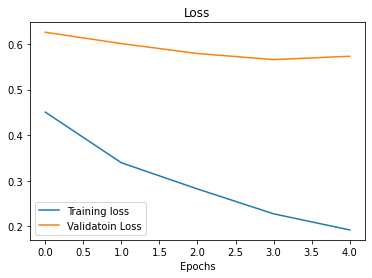

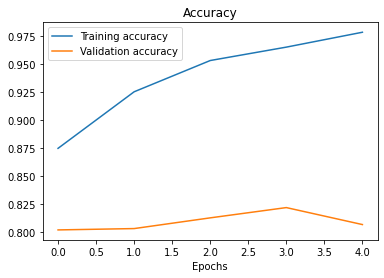

In [ ]:
plot_loss_curves(mobilenetv2_history)